# Deep learning for computer vision


This notebook will teach you to build and train convolutional networks for image recognition. Brace yourselves.

# CIFAR dataset
This week, we shall focus on the image recognition problem on cifar10 dataset
* 60k images of shape 3x32x32
* 10 different classes: planes, dogs, cats, trucks, etc.

<img src="cifar10.jpg" style="width:80%">

In [1]:
# when running in colab, un-comment this
!wget https://raw.githubusercontent.com/yandexdataschool/Practical_DL/fall19/week03_convnets/cifar.py

--2022-11-21 18:58:54--  https://raw.githubusercontent.com/yandexdataschool/Practical_DL/fall19/week03_convnets/cifar.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.108.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2396 (2.3K) [text/plain]
Saving to: ‘cifar.py’

cifar.py            100%[===================>]   2.34K  --.-KB/s    in 0s      

2022-11-21 18:58:54 (30.6 MB/s) - ‘cifar.py’ saved [2396/2396]



In [2]:
import numpy as np
from cifar import load_cifar10
import time
import torch
import torch.nn as nn
import torch.nn.functional as F

In [3]:
X_train, y_train, X_val, y_val, X_test, y_test = load_cifar10("cifar_data")

class_names = np.array(['airplane', 'automobile', 'bird', 'cat', 'deer',
                        'dog', 'frog', 'horse', 'ship', 'truck'])

print(X_train.shape, y_train.shape)

Dataset not found. Downloading...
(40000, 3, 32, 32) (40000,)


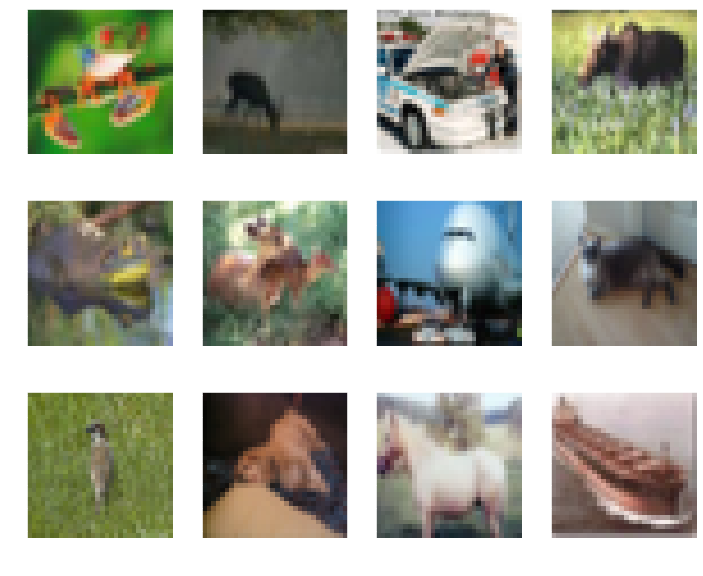

In [4]:
import matplotlib.pyplot as plt
plt.style.use("dark_background")
%matplotlib inline

plt.figure(figsize=[12,10])
for i in range(12):
    plt.subplot(3,4,i+1)
    plt.xlabel(class_names[y_train[i]])
    plt.imshow(np.transpose(X_train[i],[1,2,0]))

# Building a network

Simple neural networks with layers applied on top of one another can be implemented as `torch.nn.Sequential` - just add a list of pre-built modules and let it train.

In [5]:
import torch, torch.nn as nn
import torch.nn.functional as F

# a special module that converts [batch, channel, w, h] to [batch, units]
class Flatten(nn.Module):
    def forward(self, input):
        return input.view(input.size(0), -1)

Let's start with a dense network for our baseline:

In [6]:
device = torch.device("cuda" if torch.cuda.is_available else "cpu")
device

device(type='cuda')

In [7]:
model = nn.Sequential()

# reshape from "images" to flat vectors
model.add_module('flatten', Flatten())

# dense "head"
model.add_module('dense1', nn.Linear(3 * 32 * 32, 64))
model.add_module('dense1_relu', nn.ReLU())
model.add_module('dense2_logits', nn.Linear(64, 10)) # logits for 10 classes
model = model.to(device)

As in our basic tutorial, we train our model with negative log-likelihood aka crossentropy.

In [11]:
def compute_loss(X_batch, y_batch):
    X_batch = torch.as_tensor(X_batch, dtype=torch.float32).to(device)
    y_batch = torch.as_tensor(y_batch, dtype=torch.int64).to(device)
    logits = model(X_batch)
    return F.cross_entropy(logits, y_batch).mean().to("cpu")

In [12]:
# example
compute_loss(X_train[:5], y_train[:5])

tensor(2.3291, grad_fn=<ToCopyBackward0>)

In [8]:
test_out = model(torch.as_tensor(X_train[:5]))
test_out.shape

torch.Size([5, 10])

In [9]:
test_out.max(axis = 1)

torch.return_types.max(
values=tensor([0.1644, 0.1410, 0.2699, 0.1738, 0.1370], grad_fn=<MaxBackward0>),
indices=tensor([8, 2, 2, 2, 2]))

In [10]:
test_out.max(axis = 1)[1]

tensor([8, 2, 2, 2, 2])

### Training on minibatches
* We got 40k images, that's way too many for a full-batch SGD. Let's train on minibatches instead
* Below is a function that splits the training sample into minibatches

In [14]:
# An auxilary function that returns mini-batches for neural network training
def iterate_minibatches(X, y, batchsize):
    """Shuffle X, y, and generate batches with size = batchsize"""
    indices = np.random.permutation(np.arange(len(X)))
    for start in range(0, len(indices), batchsize):
        ix = indices[start: start + batchsize]
        yield X[ix], y[ix]

In [15]:
opt = torch.optim.SGD(model.parameters(), lr=0.01)
train_loss = []
val_accuracy = []

In [19]:
import time
num_epochs = 100 # total amount of full passes over training data
batch_size = 128  # number of samples processed in one SGD iteration

for epoch in range(num_epochs):
    # In each epoch, we do a full pass over the training data:
    start_time = time.time()
    model.train(True) # enable dropout / batch_norm training behavior
    for X_batch, y_batch in iterate_minibatches(X_train, y_train, batch_size):
        
        # train on batch
        loss = compute_loss(X_batch, y_batch)
        loss.backward()
        opt.step()
        opt.zero_grad()
        train_loss.append(loss.data.numpy())
        
    # And a full pass over the validation data:
    model.train(False) # disable dropout / use averages for batch_norm
    for X_batch, y_batch in iterate_minibatches(X_val, y_val, batch_size):
        logits = model(torch.as_tensor(X_batch, dtype=torch.float32).to(device)).to("cpu")
        
        y_pred = logits.max(axis = 1)[1].data.numpy()
        val_accuracy.append(np.mean(y_batch == y_pred))

    
    # Then we print the results for this epoch:
    print("Epoch {}/{} took {:.3f}s".format(
        epoch + 1, num_epochs, time.time() - start_time))
    print("  training loss (in-iteration): \t{:.6f}".format(
        np.mean(train_loss[-len(X_train) // batch_size :])))
    print("  validation accuracy: \t\t\t{:.2f} %".format(
        np.mean(val_accuracy[-len(X_val) // batch_size :]) * 100))

Epoch 1/100 took 0.586s
  training loss (in-iteration): 	1.889047
  validation accuracy: 			35.06 %
Epoch 2/100 took 0.658s
  training loss (in-iteration): 	1.847548
  validation accuracy: 			36.51 %
Epoch 3/100 took 0.571s
  training loss (in-iteration): 	1.814483
  validation accuracy: 			37.69 %
Epoch 4/100 took 0.544s
  training loss (in-iteration): 	1.786170
  validation accuracy: 			37.86 %
Epoch 5/100 took 0.631s
  training loss (in-iteration): 	1.762104
  validation accuracy: 			39.03 %
Epoch 6/100 took 0.630s
  training loss (in-iteration): 	1.740353
  validation accuracy: 			39.29 %
Epoch 7/100 took 0.584s
  training loss (in-iteration): 	1.720476
  validation accuracy: 			39.86 %
Epoch 8/100 took 0.522s
  training loss (in-iteration): 	1.703652
  validation accuracy: 			41.40 %
Epoch 9/100 took 0.538s
  training loss (in-iteration): 	1.688080
  validation accuracy: 			41.13 %
Epoch 10/100 took 0.533s
  training loss (in-iteration): 	1.673841
  validation accuracy: 			41.33 %

In [23]:
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

def class_accuracy(model, X, y):
    class_correct = [0 for _ in range(10)]
    class_total = [0 for _ in range(10)]
    batchsize = 64
    with torch.no_grad():
        for X_batch, y_batch in iterate_minibatches(X, y, batchsize = batchsize):
            logits = model(torch.as_tensor(X_batch, dtype=torch.float32).to(device)).to("cpu")
            y_pred = logits.max(axis = 1)[1].data.numpy()
            c = (y_pred == y_batch).squeeze()

            for i in range(len(c)):
                    label = y_batch[i]
                    class_correct[label] += c[i].item()
                    class_total[label] += 1
    print("Accuracy of: ")
    print()
    for i in range(10):
        print('   {}: {:.2f} %'.format(
            classes[i], 100 * class_correct[i] / class_total[i]))
        
class_accuracy(model, X_train, y_train)

Accuracy of: 

   plane: 64.00 %
   car: 63.54 %
   bird: 44.02 %
   cat: 46.27 %
   deer: 43.90 %
   dog: 37.32 %
   frog: 72.32 %
   horse: 61.58 %
   ship: 67.64 %
   truck: 73.34 %


Don't wait for full 100 epochs. You can interrupt training after 5-20 epochs once validation accuracy stops going up.
```

```

```

```

```

```

```

```

```

```

### Final test

In [24]:
model.train(False) # disable dropout / use averages for batch_norm
test_batch_acc = []
for X_batch, y_batch in iterate_minibatches(X_test, y_test, 500):
    logits = model(torch.as_tensor(X_batch, dtype=torch.float32).to(device)).to("cpu")
    y_pred = logits.max(1)[1].data.numpy()
    test_batch_acc.append(np.mean(y_batch == y_pred))

test_accuracy = np.mean(test_batch_acc)
    
print("Final results:")
print("  test accuracy:\t\t{:.2f} %".format(
    test_accuracy * 100))

if test_accuracy * 100 > 95:
    print("Double-check, than consider applying for NIPS'17. SRSly.")
elif test_accuracy * 100 > 90:
    print("U'r freakin' amazin'!")
elif test_accuracy * 100 > 80:
    print("Achievement unlocked: 110lvl Warlock!")
elif test_accuracy * 100 > 70:
    print("Achievement unlocked: 80lvl Warlock!")
elif test_accuracy * 100 > 60:
    print("Achievement unlocked: 70lvl Warlock!")
elif test_accuracy * 100 > 50:
    print("Achievement unlocked: 60lvl Warlock!")
else:
    print("We need more magic! Follow instructons below")

Final results:
  test accuracy:		50.47 %
Achievement unlocked: 60lvl Warlock!


## Task I: small convolution net
### First step

Let's create a mini-convolutional network with roughly such architecture:
* Input layer
* 3x3 convolution with 10 filters and _ReLU_ activation
* 2x2 pooling (or set previous convolution stride to 3)
* Flatten
* Dense layer with 100 neurons and _ReLU_ activation
* 10% dropout
* Output dense layer.


__Convolutional layers__ in torch are just like all other layers, but with a specific set of parameters:

__`...`__

__`model.add_module('conv1', nn.Conv2d(in_channels=3, out_channels=10, kernel_size=3)) # convolution`__

__`model.add_module('pool1', nn.MaxPool2d(2)) # max pooling 2x2`__

__`...`__


Once you're done (and compute_loss no longer raises errors), train it with __Adam__ optimizer with default params (feel free to modify the code above).

If everything is right, you should get at least __50%__ validation accuracy.

In [35]:
model_2 = nn.Sequential(nn.Conv2d(3, 10, 3),
                        nn.ReLU(),
                        nn.MaxPool2d(2),
                        nn.Flatten(),
                        nn.Linear(15*15*10, 100),
                        nn.Dropout(0.9),
                        nn.Linear(100, 10)
                       ).to(device)

test_out_2 = model_2(torch.as_tensor(X_train[:5]).to(device))
test_out_2.shape

torch.Size([5, 10])

In [36]:
def train_model(model, X_train, X_val, y_train, y_val, 
                opt, criterion,  num_epochs=15, batch_size=128):

    for epoch in range(num_epochs):
        # In each epoch, we do a full pass over the training data:
        start_time = time.time()
        model.train(True) # enable dropout / batch_norm training behavior
        for X_batch, y_batch in iterate_minibatches(X_train, y_train, batch_size):
            # train on batch
            output = model(torch.as_tensor(X_batch).to(device)).to("cpu")
            loss = criterion(output, torch.as_tensor(y_batch, dtype = torch.long))
            loss.backward()
            opt.step()
            opt.zero_grad()
            train_loss.append(loss.data.numpy())

        # And a full pass over the validation data:
        model.train(False) # disable dropout / use averages for batch_norm
        for X_batch, y_batch in iterate_minibatches(X_val, y_val, batch_size):
            logits = model(torch.as_tensor(X_batch, dtype=torch.float32).to(device)).to("cpu")
            y_pred = logits.max(axis = 1)[1].data.numpy()
            val_accuracy.append(np.mean(y_batch == y_pred))


        # Then we print the results for this epoch:
        print("Epoch {}/{} took {:.3f}s".format(
            epoch + 1, num_epochs, time.time() - start_time))
        print("  training loss (in-iteration): \t{:.6f}".format(
            np.mean(train_loss[-len(X_train) // batch_size :])))
        print("  validation accuracy: \t\t\t{:.2f} %".format(
            np.mean(val_accuracy[-len(X_val) // batch_size :]) * 100))

In [37]:
opt = torch.optim.Adam(model_2.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()
train_model(model_2, X_train, X_val, y_train, y_val, opt, criterion, num_epochs=50)

Epoch 1/50 took 0.872s
  training loss (in-iteration): 	1.980953
  validation accuracy: 			43.15 %
Epoch 2/50 took 1.008s
  training loss (in-iteration): 	1.746213
  validation accuracy: 			45.00 %
Epoch 3/50 took 0.903s
  training loss (in-iteration): 	1.672690
  validation accuracy: 			49.77 %
Epoch 4/50 took 1.111s
  training loss (in-iteration): 	1.630761
  validation accuracy: 			50.28 %
Epoch 5/50 took 0.939s
  training loss (in-iteration): 	1.617312
  validation accuracy: 			49.73 %
Epoch 6/50 took 0.856s
  training loss (in-iteration): 	1.592674
  validation accuracy: 			51.90 %
Epoch 7/50 took 0.869s
  training loss (in-iteration): 	1.574315
  validation accuracy: 			51.74 %
Epoch 8/50 took 0.868s
  training loss (in-iteration): 	1.564838
  validation accuracy: 			53.46 %
Epoch 9/50 took 0.871s
  training loss (in-iteration): 	1.549976
  validation accuracy: 			52.95 %
Epoch 10/50 took 0.879s
  training loss (in-iteration): 	1.539713
  validation accuracy: 			51.91 %
Epoch 11/

In [38]:
class_accuracy(model_2, X_val, y_val)

Accuracy of: 

   plane: 57.85 %
   car: 71.83 %
   bird: 36.78 %
   cat: 26.94 %
   deer: 48.03 %
   dog: 60.14 %
   frog: 75.53 %
   horse: 70.37 %
   ship: 66.03 %
   truck: 72.84 %


```

```

```

```

```

```

```

```

```

```

__Hint:__ If you don't want to compute shapes by hand, just plug in any shape (e.g. 1 unit) and run compute_loss. You will see something like this:

__`RuntimeError: size mismatch, m1: [5 x 1960], m2: [1 x 64] at /some/long/path/to/torch/operation`__

See the __1960__ there? That's your actual input shape.

## Task 2: adding normalization

* Add batch norm (with default params) between convolution and ReLU
  * nn.BatchNorm*d (1d for dense, 2d for conv)
  * usually better to put them after linear/conv but before nonlinearity
* Re-train the network with the same optimizer, it should get at least 60% validation accuracy at peak.



In [40]:
model_3 = nn.Sequential(nn.Conv2d(3, 10, 3),
                        nn.BatchNorm2d(10),
                        nn.ReLU(),
                        nn.MaxPool2d(2),
                        nn.Flatten(),
                        nn.Linear(15*15*10, 100),
                        nn.BatchNorm1d(100),
                        nn.Dropout(0.9),
                        nn.Linear(100, 10)
                       ).to(device)

opt = torch.optim.Adam(model_3.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()
train_model(model_3, X_train, X_val, y_train, y_val, opt, criterion, num_epochs=50)

Epoch 1/50 took 1.240s
  training loss (in-iteration): 	1.993759
  validation accuracy: 			48.83 %
Epoch 2/50 took 1.030s
  training loss (in-iteration): 	1.680322
  validation accuracy: 			44.56 %
Epoch 3/50 took 1.190s
  training loss (in-iteration): 	1.632258
  validation accuracy: 			51.86 %
Epoch 4/50 took 1.035s
  training loss (in-iteration): 	1.599452
  validation accuracy: 			53.01 %
Epoch 5/50 took 1.033s
  training loss (in-iteration): 	1.570973
  validation accuracy: 			50.77 %
Epoch 6/50 took 1.023s
  training loss (in-iteration): 	1.546096
  validation accuracy: 			51.58 %
Epoch 7/50 took 1.038s
  training loss (in-iteration): 	1.527054
  validation accuracy: 			54.88 %
Epoch 8/50 took 1.046s
  training loss (in-iteration): 	1.508704
  validation accuracy: 			53.09 %
Epoch 9/50 took 1.051s
  training loss (in-iteration): 	1.491482
  validation accuracy: 			55.14 %
Epoch 10/50 took 1.046s
  training loss (in-iteration): 	1.481951
  validation accuracy: 			47.26 %
Epoch 11/

In [41]:
class_accuracy(model_3, X_val, y_val)

Accuracy of: 

   plane: 63.38 %
   car: 73.00 %
   bird: 38.74 %
   cat: 21.12 %
   deer: 67.81 %
   dog: 42.81 %
   frog: 71.80 %
   horse: 74.66 %
   ship: 50.95 %
   truck: 75.95 %



```

```

```

```

```

```

```

```

```

```

```

```

```

```
## Task 3: Data Augmentation

There's a powerful torch tool for image preprocessing useful to do data preprocessing and augmentation.

Here's how it works: we define a pipeline that
* makes random crops of data (augmentation)
* randomly flips image horizontally (augmentation)
* then normalizes it (preprocessing)

In [42]:
from torchvision import transforms
means = np.array((0.4914, 0.4822, 0.4465))
stds = np.array((0.2023, 0.1994, 0.2010))

transform_augment = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomRotation([-30, 30]),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(means, stds),
])

In [43]:
from torchvision.datasets import CIFAR10
train_loader = CIFAR10("./cifar_data/", train=True, transform=transform_augment)

train_batch_gen = torch.utils.data.DataLoader(train_loader, 
                                              batch_size=32,
                                              shuffle=True,
                                              num_workers=1)

X: <class 'torch.Tensor'> torch.Size([32, 3, 32, 32])
y: <class 'torch.Tensor'> torch.Size([32])


NotImplementedError: Plese use this code in your training loop

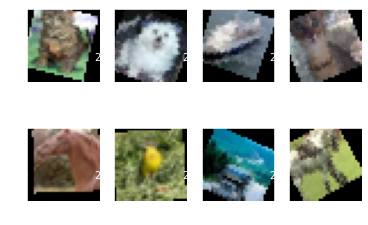

In [44]:

for (x_batch, y_batch) in train_batch_gen:
    
    print('X:', type(x_batch), x_batch.shape)
    print('y:', type(y_batch), y_batch.shape)
    
    for i, img in enumerate(x_batch.numpy()[:8]):
        plt.subplot(2, 4, i+1)
        plt.imshow(img.transpose([1,2,0]) * stds + means )
        
    
    raise NotImplementedError("Plese use this code in your training loop")
    # TODO use this in your training loop

In [46]:
def train_model_with_torch_loader(model, train_loader, opt, criterion,  num_epochs=15, batch_size=128):

    for epoch in range(num_epochs):
        # In each epoch, we do a full pass over the training data:
        start_time = time.time()
        model.train(True) # enable dropout / batch_norm training behavior
        for X_batch, y_batch in train_loader:
            # train on batch
            output = model(torch.as_tensor(X_batch).to(device)).to("cpu")
            loss = criterion(output, torch.as_tensor(y_batch, dtype = torch.long))
            loss.backward()
            opt.step()
            opt.zero_grad()
            train_loss.append(loss.data.numpy())


        # Then we print the results for this epoch:
        print("Epoch {}/{} took {:.3f}s".format(
            epoch + 1, num_epochs, time.time() - start_time))
        print("  training loss (in-iteration): \t{:.6f}".format(
            np.mean(train_loss[-len(X_train) // batch_size :])))

In [71]:
def class_accuracy(model, loader):
    class_correct = [0 for _ in range(10)]
    class_total = [0 for _ in range(10)]
    batchsize = 64
    with torch.no_grad():
        for X_batch, y_batch in loader:
            logits = model(torch.as_tensor(X_batch, dtype=torch.float32).to(device)).to("cpu")
            y_pred = logits.max(axis = 1)[1].data.numpy()
            c = y_batch.detach().numpy() == y_pred

            for i in range(len(c)):
                    label = y_batch[i]
                    class_correct[label] += c[i].item()
                    class_total[label] += 1
    print("Accuracy of: ")
    print()
    for i in range(10):
        print('   {}: {:.2f} %'.format(
            classes[i], 100 * class_correct[i] / class_total[i]))

In [75]:
model_4 = nn.Sequential(nn.Conv2d(3, 10, 3),
                        nn.BatchNorm2d(10),
                        nn.ReLU(),
                        nn.MaxPool2d(2),
                        nn.Flatten(),
                        nn.Linear(15*15*10, 100),
                        nn.BatchNorm1d(100),
                        nn.Dropout(0.1),
                        nn.Linear(100, 10)
                       ).to(device)

opt = torch.optim.SGD(model_4.parameters(), lr=0.001, momentum = 0.9, nesterov=True)
criterion = nn.CrossEntropyLoss()
train_model_with_torch_loader(model_4, train_batch_gen, opt, criterion, num_epochs=50)

Epoch 1/50 took 37.074s
  training loss (in-iteration): 	1.649164
Epoch 2/50 took 37.387s
  training loss (in-iteration): 	1.588249
Epoch 3/50 took 37.022s
  training loss (in-iteration): 	1.566046
Epoch 4/50 took 37.134s
  training loss (in-iteration): 	1.551784
Epoch 5/50 took 38.848s
  training loss (in-iteration): 	1.540781
Epoch 6/50 took 38.488s
  training loss (in-iteration): 	1.514035
Epoch 7/50 took 39.098s
  training loss (in-iteration): 	1.508757
Epoch 8/50 took 39.383s
  training loss (in-iteration): 	1.509652
Epoch 9/50 took 38.806s
  training loss (in-iteration): 	1.515203
Epoch 10/50 took 37.804s
  training loss (in-iteration): 	1.482781


KeyboardInterrupt: 

When testing, we don't need random crops, just normalize with same statistics.

In [76]:
transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(means, stds),
])

test_loader = CIFAR10("./cifar_data/", train=False, transform=transform_test)

test_batch_gen = torch.utils.data.DataLoader(test_loader, 
                                             batch_size=32,
                                             shuffle=False,
                                             num_workers=1)


In [77]:
class_accuracy(model_4, test_batch_gen)

Accuracy of: 

   plane: 59.60 %
   car: 68.10 %
   bird: 30.70 %
   cat: 29.20 %
   deer: 44.00 %
   dog: 52.30 %
   frog: 63.40 %
   horse: 62.30 %
   ship: 64.30 %
   truck: 55.90 %


In [78]:
model_5 = nn.Sequential(nn.Conv2d(3, 64, 3),
                        nn.BatchNorm2d(64),
                        nn.ReLU(),
                        nn.Conv2d(64, 64, 3),
                        nn.BatchNorm2d(64),
                        nn.ReLU(),
                        nn.MaxPool2d(2),
                        nn.Flatten(),
                        nn.Linear(14*14*64, 100),
                        nn.BatchNorm1d(100),
                        nn.ReLU(),
                        nn.Dropout(0.1),
                        nn.Linear(100, 10)
                       ).to(device)

opt = torch.optim.SGD(model_5.parameters(), lr=0.001, momentum = 0.9, nesterov=True)
criterion = nn.CrossEntropyLoss()
train_model_with_torch_loader(model_5, train_batch_gen, opt, criterion, num_epochs=10)

Epoch 1/10 took 38.958s
  training loss (in-iteration): 	1.461119
Epoch 2/10 took 39.556s
  training loss (in-iteration): 	1.332966
Epoch 3/10 took 38.734s
  training loss (in-iteration): 	1.302873
Epoch 4/10 took 39.524s
  training loss (in-iteration): 	1.254817
Epoch 5/10 took 38.069s
  training loss (in-iteration): 	1.184272
Epoch 6/10 took 39.844s
  training loss (in-iteration): 	1.177284
Epoch 7/10 took 38.614s
  training loss (in-iteration): 	1.145628
Epoch 8/10 took 39.618s
  training loss (in-iteration): 	1.120535
Epoch 9/10 took 38.610s
  training loss (in-iteration): 	1.109687
Epoch 10/10 took 39.360s
  training loss (in-iteration): 	1.095018


In [79]:
class_accuracy(model_5, test_batch_gen)

Accuracy of: 

   plane: 73.70 %
   car: 82.40 %
   bird: 52.50 %
   cat: 47.60 %
   deer: 55.40 %
   dog: 57.60 %
   frog: 76.00 %
   horse: 73.10 %
   ship: 81.00 %
   truck: 71.90 %


In [87]:
print(f"Total accuracy for model_1: {total_accuracy(model, test_batch_gen):.3f} %")
print(f"Total accuracy for model_1: {total_accuracy(model_2, test_batch_gen):.3f} %")
print(f"Total accuracy for model_1: {total_accuracy(model_3, test_batch_gen):.3f} %")
print(f"Total accuracy for model_1: {total_accuracy(model_4, test_batch_gen):.3f} %")

Total accuracy for model 1: 28.764 %


In [86]:
def total_accuracy(model, test_loader):
    model.train(False) # disable dropout / use averages for batch_norm
    test_batch_acc = []
    for X_batch, y_batch in test_loader:
        logits = model(torch.as_tensor(X_batch, dtype=torch.float32).to(device)).to("cpu")
        y_pred = logits.max(1)[1].data.numpy()
        test_batch_acc.append(np.mean(y_batch.detach().numpy() == y_pred))

    test_accuracy = np.mean(test_batch_acc)

    return test_accuracy*100


In [88]:
print(f"Total accuracy for model_1: {total_accuracy(model, test_batch_gen):.3f} %")
print(f"Total accuracy for model_2: {total_accuracy(model_2, test_batch_gen):.3f} %")
print(f"Total accuracy for model_3: {total_accuracy(model_3, test_batch_gen):.3f} %")
print(f"Total accuracy for model_4: {total_accuracy(model_4, test_batch_gen):.3f} %")
print(f"Total accuracy for model_5: {total_accuracy(model_5, test_batch_gen):.3f} %")

Total accuracy for model_1: 37.570 %
Total accuracy for model_2: 28.764 %
Total accuracy for model_3: 39.247 %
Total accuracy for model_4: 54.653 %
Total accuracy for model_5: 69.848 %
